# Priors and posterior predictions with Bagpipes

These exercises will take you through some examples to aid understanding of the effects of priors in spectral fitting. All the information you need to complete them should be available in the [Bagpipes documentation](https://bagpipes.readthedocs.io), or the [Jupyter notebook examples](https://github.com/ACCarnall/bagpipes/tree/master/examples) on the Bagpipes github repository. I'll be on hand during the session to discuss things with you, and provide advice if anything is confusing.

If you're new to Google Colab, this file is a Jupyter notebook running inside its own virtual machine on the Google servers, which I've pre-loaded with all the necessary software. This should allow you to get straight on with running the, code without having to worry about installation issues.

You can copy this document into your own Google drive to begin editing it. If you get into trouble, you can restart or factory reset the notebook/virtual machine under the Runtime menu at the top. You'll need to run the first cell to install the necessary software before getting started.

In [1]:
# This first cell sets up the virtual machine with all the necessary software.
# There should be no need to edit this cell, just scroll down...

# Install Bagpipes and python dependencies
!pip install bagpipes

# Install MultiNest
!git clone https://www.github.com/johannesbuchner/multinest.git
!cd multinest/build && cmake .. && make && sudo make install

# Install PyMultiNest (with hacky solution to path issues)
!git clone https://www.github.com/ACCarnall/PyMultiNest
!cp -r PyMultiNest/pymultinest /usr/local/lib/python3.7/dist-packages/

# Install latex for plots
!sudo apt-get install texlive-latex-recommended
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
!unzip type1cm.zip -d /tmp/type1cm
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
!sudo mkdir /usr/share/texmf/tex/latex/type1cm
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
!sudo texhash
!apt install cm-super

# Get the filter curves needed for the examples
!git clone https://github.com/ACCarnall/bagpipes
!mv bagpipes/examples/filters .
!rm -r bagpipes

# Adjust the output height to avoid a huge wall of installation text
from IPython import display
display.Javascript("google.colab.output.setIframeHeight('100px');")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.0/206.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 6.1 MB/s eta 0:00:00
Cloning into 'multinest'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 549 (delta 65), reused 49 (delta 19), pack-reused 431
Receiving objects: 100% (549/549), 300.02 KiB | 1.52 MiB/s, done.
Resolving deltas: 100% (342/342), done.
CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The Fortran compiler identification is GNU 11.4.0
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting Fortran compiler ABI info
-- D

<IPython.core.display.Javascript object>

In [2]:
# Import necessary python modules

import numpy as np
import bagpipes as pipes
import os

BAGPIPES: Generating IGM absorption table.


# Understanding your priors within Bagpipes

One of the major problems with spectral fitting, in particular with star-formation histories (SFHs), is that the priors you set aren't directly applied to the parameters you're interested in constraining. For example, you might be interested in constraining the star-formation rate, but only set priors on the onset time and exponential timescale for an exponentially declining SFH.

Bagpipes provides an interface to define a model and then sample directly from the priors that model imposes on parameters of interest, such as stellar ages, star-formation rates, etc. To begin with, let's define an example model (or fit_instructions dictionary) that could be used to fit observational data. We'll simplify things by using a fixed redshift.

In [3]:

exp = {}
exp["age"] = (0.1, 15.)
exp["tau"] = (0.3, 15.)
exp["massformed"] = (0., 13.)
exp["metallicity"] = (0., 2.5)

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 4.)

fit_info = {}
fit_info["exponential"] = exp
fit_info["nebular"] = nebular
fit_info["dust"] = dust
fit_info["redshift"] = 1.


We can obtain samples from this model/set of priors as shown below. As standard within Bagpipes, we need to define some data we want to obtain predictions for, though the class isn't currently set up to return predictions for these data (I can add this easily if it's a function someone would like to use in their research). At random, let's pick data that looks something like what you might get from NIRSpec observations using the G140M grating with the F070LP filter.

In [4]:
prior = pipes.fitting.check_priors(fit_info,
                                   spec_wavs=np.arange(7000., 12700., 10.),
                                   n_draws=10000)

/usr/local/lib/python3.10/dist-packages/bagpipes/models/model_galaxy.py:312: RuntimeWarning: The requested model includes stars which formed before the Big Bang, no spectrum generated.
  warnings.warn("The requested model includes stars which formed "


Let's first take a look at the prior this model imposes on the specific star-formation rate.

Prior percentiles: 16th, 50th, 84th
log_10(sSFR/yr^-1): ['-10.42', '-9.88', '-9.28']


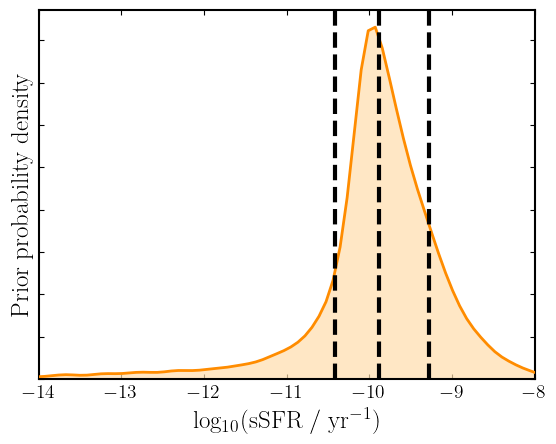

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
pipes.plotting.update_rcParams()

fig = plt.figure()
ax = plt.subplot()

pipes.plotting.hist1d(prior.samples["ssfr"], ax, smooth=True,
                      label="$\mathrm{log_{10}(sSFR\ /\ yr^{-1})}$",
                      percentiles=True, bins=250)

lim = ax.set_xlim(-14., -8.)
tick = ax.set_xticks(np.arange(-14, -7))

ax.set_ylabel("$\mathrm{Prior\ probability\ density}$")

percentiles = np.percentile(prior.samples["ssfr"], (16, 50, 84))

print("Prior percentiles: 16th, 50th, 84th")

print("log_10(sSFR/yr^-1):", ["%.2f" % p for p in percentiles])

You can see that the prior is strongly peaked, with the bulk of the prior probability lying within a \~1 dex range, centred on \~10^-10 Solar masses per year. This could be an issue, for example, if you were interested in fitting a large sample of z\~1 star-forming galaxies with this model to try to understand the scatter in the star-forming main sequence, as we've already (accidentally) defined a strong prior on galaxy sSFRs.

Now try making some changes to the above model and testing out how these affect the prior on sSFR. You can change the limits on the allowed ranges of parameter values, change the prior probability density between these limits (e.g. exp["tau_prior"] = "log_10"), or switch to an entirely new star-formation history model.  You might also like to look at other parameters of interest, for example mass-weighted age.



In [6]:
# Your code here








# How do priors interact with data?

The interaction between priors and data can be subtle. In the limit of extremely strongly constraining data, the correct solution should be reached no matter the prior chosen. Sadly, this is a situation that rarely, if ever, exists in spectral fitting analyses. With weakly constraining data, the prior can play a significant role in determining the outcome of a spectral fitting analysis.

To demonstrate this, let's bring back the mock data from the first notebook.

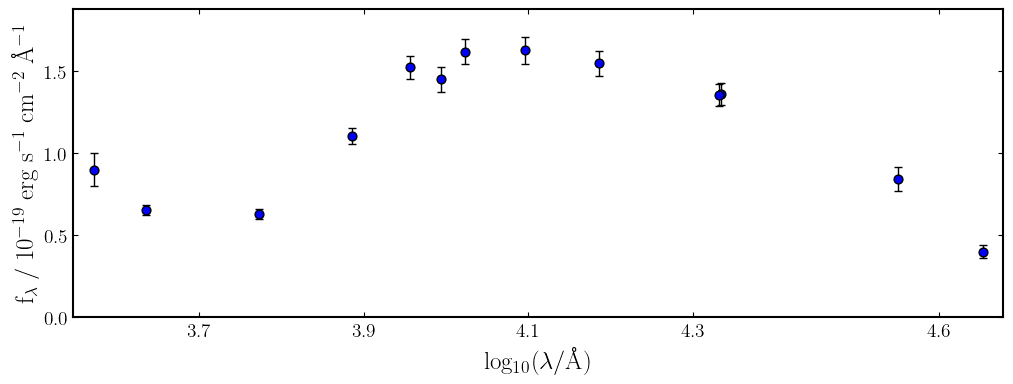

In [7]:
filters = ["VIMOS_U", "f435w", "f606w", "f775w", "f850lp", "f098m", "f105w",
           "f125w", "f160w", "ISAAC_Ks", "HAWKI_K", "IRAC1", "IRAC2"]

filter_list = ["filters/" + f for f in filters]

fluxes = np.array([0.0417, 0.0406, 0.0734, 0.2180, 0.4146, 0.4708,
                   0.6016, 0.8458, 1.2198, 2.1265, 2.0803, 3.5459,
                   2.6934]) #microJanskys

fluxerrs = np.array([0.0047, 0.0019, 0.0035, 0.0098, 0.0189, 0.0247,
                     0.0287, 0.0426, 0.0613, 0.1041, 0.1032, 0.3095,
                     0.2502]) #microJanskys

def load_data(ID):
    return np.c_[fluxes, fluxerrs]

galaxy = pipes.galaxy("mystery", load_data, filt_list=filter_list,
                      spectrum_exists=False)

fig = galaxy.plot()

I'm also going to fit these data with the exponentially declining SFH model we defined above.

In [ ]:
fit = pipes.fit(galaxy, fit_info, run="test1")

fit.fit()



Bagpipes: fitting object mystery



You can see we obtain fairly reasonable looking constraints on the star-formation history:

In [ ]:
fig = fit.plot_sfh_posterior(show=True, save=False)

Now, take one or more of the other models you defined and sampled the priors of earlier on. Fit the data with this new model and see how the fitted SFH changes. Given that the shaded region on the plot above is the 1-sigma confidence interval, do the different models give consistent answers?

In [ ]:
# Your code here








Often, it's true that not only do different models/sets of priors give very different answers for galaxy physical parameters, the quality of fit to photometric data is indistinguishable, meaning you cannot discriminate between the two possible solutions. You can attempt to investigate this for the two fits in this example if you'd like to.

This result means that a carefully chosen, physically motivated set of priors is a crucial ingredient in spectral fitting. This will always affect the results you obtain to some extent, depending on data quality (see Kartheik's Notebook 4).

# What can we do about prior-dependence?

Hopefully from the example above you've convinced yourself that priors can play an extremely important role in determining the answers you get for key parameters, such as SFRs and stellar ages, when fitting photometry. What should we do about this?

On the way to answering this question, I'm going to take the chance to demonstrate to you another cool feature of Bagpipes I haven't got round to documenting yet. Posterior predictions for new data.

Using the results of the fit I did above, I can produce a prediction for what NIRSPEC observations I touched on above, with the G140M grating and F070LP filter, would look like.

In [ ]:
nirspec_wavs = np.arange(7000., 12700., 10.)

fit.posterior.predict(spec_wavs=nirspec_wavs)

print(fit.posterior.prediction["spectrum"].shape)

Now we have an array of shape (n samples from the posterior, n wavelength points). To get the posterior median prediction for the NIRSPEC spectrum we can do:

In [ ]:
post_med = np.median(fit.posterior.prediction["spectrum"], axis=0)

fig = plt.figure(figsize=(18, 6))
ax = plt.subplot()

pipes.plotting.add_spectrum(np.c_[nirspec_wavs, post_med], ax)


Now, generate the corresponding prediciton for your other fit to the data using the different model. Supposing the mystery galaxy were observed with NIRSPEC, would you be able to differentiate between the two fits based on these new data?

In [ ]:
# Your code here








The concepts introduced in this notebook were the basis of two papers published in 2019, discussing the information content of photometry, and the necessity of appropriate models to constrain subtle parameters:

https://ui.adsabs.harvard.edu/abs/2019ApJ...873...44C/abstract

https://ui.adsabs.harvard.edu/abs/2019ApJ...876....3L/abstract

The examples presented may help aid understanding of how best photometry can be used to constrain galaxy physical parameters, with a particular focus on star-formation histories.